In [53]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.data import Dataset
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [54]:
from src.model_fit_funcs import load_image, make_ds, build_model, finetune

In [55]:
model_test, base_test = build_model()
model_test.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ included_input (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GAP_Head                        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Regressor (Dense)               │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [56]:
finetune(model_test, base_test)
model_test.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ included_input (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GAP_Head                        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Regressor (Dense)               │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 1,854,465 (7.07 MB)

 Non-trainable params: 1,375,424 (5.25 MB)

# Carregando o arquivo com os rankings dos hiperparâmetros

In [57]:
best_score = pd.read_csv('reports\\random_search_20251023_202559.csv')

In [58]:
best_score.head(5)

trial  lr_head     lr_ft  ep_head  ep_ft  n_unfreeze        r2
0     15   0.0001  0.000300       15     10          15  0.905133
1      8   0.0001  0.000300       10     10          15  0.728941
2      1   0.0001  0.000300       20     10           8  0.704817
3      4   0.0030  0.000001       20     10           5  0.701162
4     13   0.0030  0.000300       15     20           8  0.657441

In [59]:
best_score.iloc[0]['trial']

np.float64(15.0)

In [60]:
b_lr_head = float(best_score.iloc[0]['lr_head'])
b_lr_ft = float(best_score.iloc[0]['lr_ft'])
b_ep_head = int(best_score.iloc[0]['ep_head'])
b_ep_ft = int(best_score.iloc[0]['ep_ft'])
b_n_unfreeze = int(best_score.iloc[0]['n_unfreeze'])

# Criação do Dataset

In [61]:
df = pd.read_csv('resultados.csv')

In [62]:
paths_imagens = df['file_path']
y = df['Resultados']

In [63]:
ds = make_ds(paths_imagens, y, batch_size=8)

# Ajuste com todo o dataset

In [64]:
cb = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6), # Monitoramento por loss, sem validação
]

In [65]:
# Criação do backbone
model, base = build_model(b_lr_head)

In [66]:
# Treinamento da head
model.fit(ds, epochs=b_ep_head, callbacks=cb, verbose=0)


In [67]:
# Descongelamento de camadas
finetune(model, base, lr=b_lr_ft, n_unfreeze=b_n_unfreeze)

In [68]:
# Fine-tuning
model.fit(ds, epochs=b_ep_ft,  callbacks=[cb], verbose=0)

In [69]:
model.save('models\\modelo_final.keras')

# R²

In [70]:
# Separação das imagens e das predições

ds_x = ds.map(lambda x, y: x)
ds_y = ds.map(lambda x, y: y)

In [71]:
# Predição
y_pred = model.predict(ds_x).squeeze()

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step                                              


In [72]:
# Unbatch e emparelhamento com as previsões
ds_x_unb = ds_x.unbatch()
ds_y_unb = ds_y.unbatch()
ds_pred = Dataset.from_tensor_slices(y_pred)

ds_hat = Dataset.zip((ds_x_unb,ds_y_unb,ds_pred))

In [73]:
ys, yhats = [], []
for _, y, yhat in ds_hat:
    ys.append(float(y.numpy()))
    yhats.append(float(yhat.numpy()))

ys = np.asarray(ys)
yhats = np.asarray(yhats)

r2 = r2_score(ys, yhats)

In [74]:
print("R²:", r2)

R²: -0.012838040607018764


# Valores reais e previsões por imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0690929..1.034961].


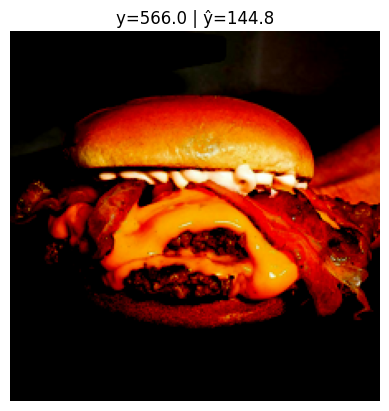

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1444627..1.1323922].


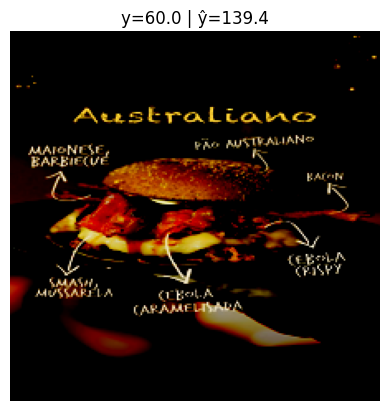

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0021031..0.099497914].


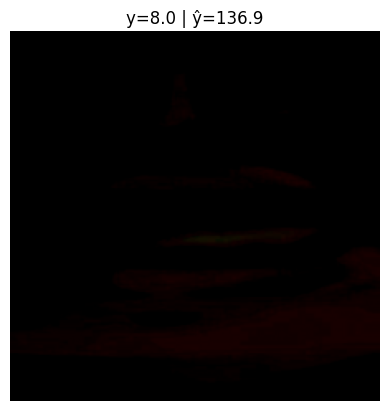

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0863185..1.1325092].


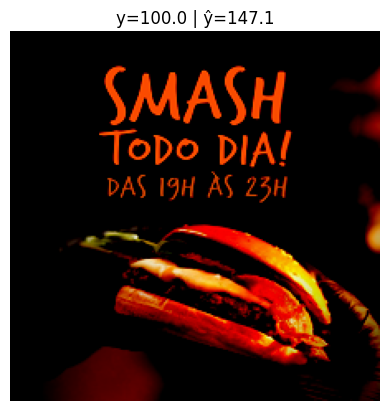

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.051402..1.0467377].


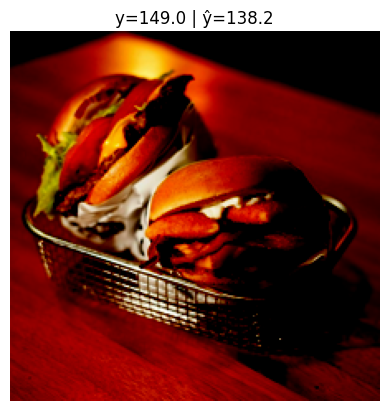

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0227689..1.0035486].


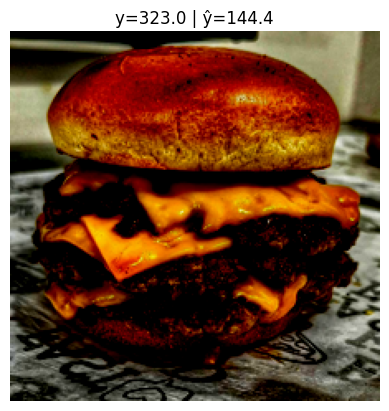

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1444627..1.1323922].


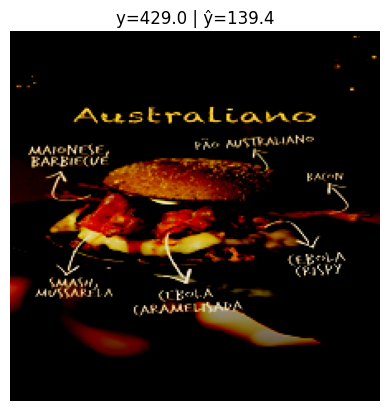

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0219052..1.1949637].


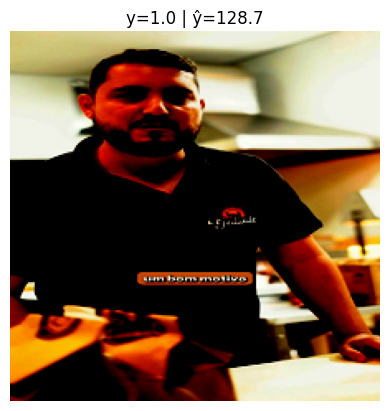

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1444627..1.1323922].


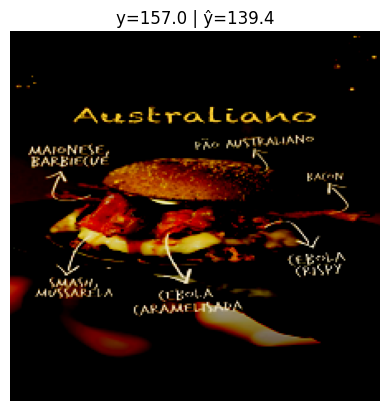

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0933112..1.1119454].


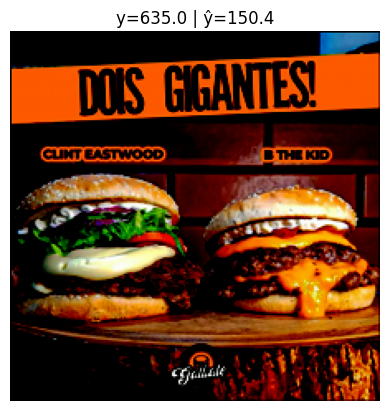

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0728135..1.0992837].


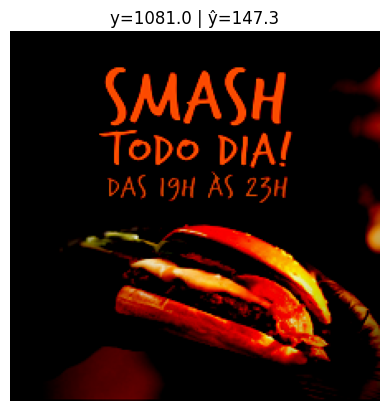

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0907598..1.1175172].


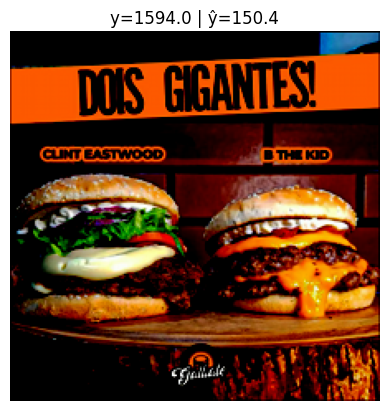

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0808966..1.1154242].


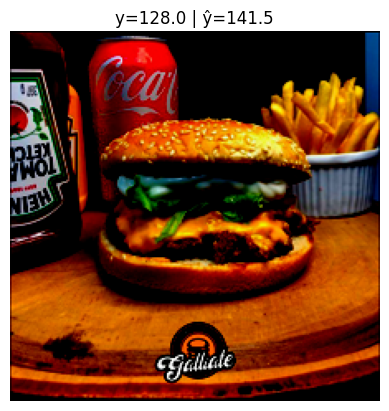

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0469756..1.0262425].


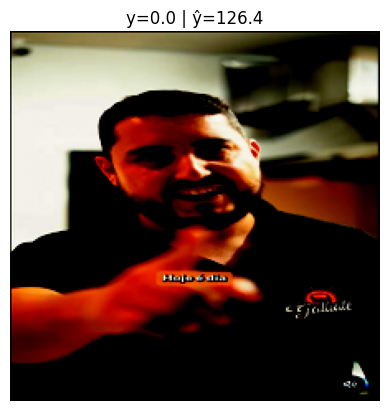

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1519954..1.0980203].


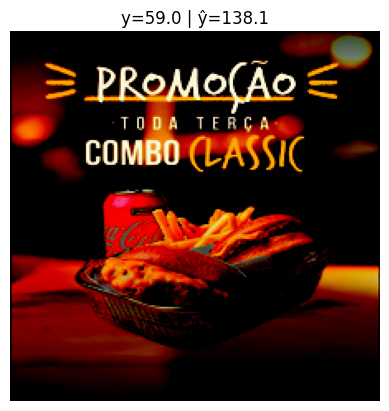

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.047355..0.9863496].


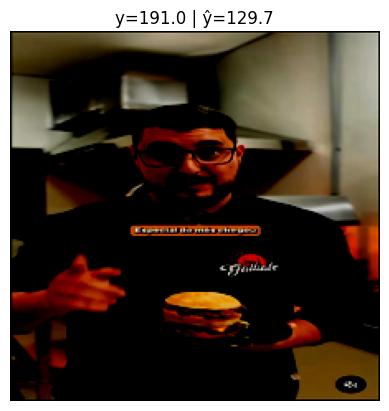

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0397816..1.1599452].


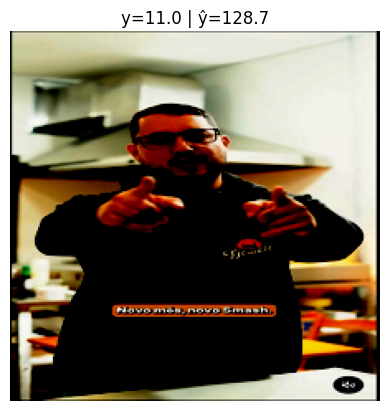

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0169027..1.1137989].


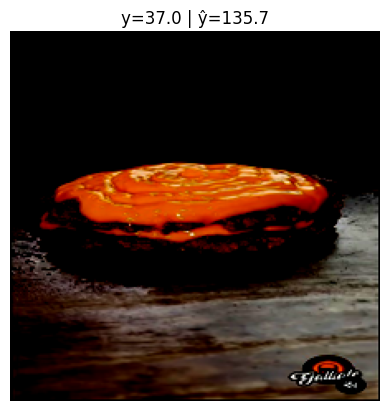

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1803674..1.1076088].


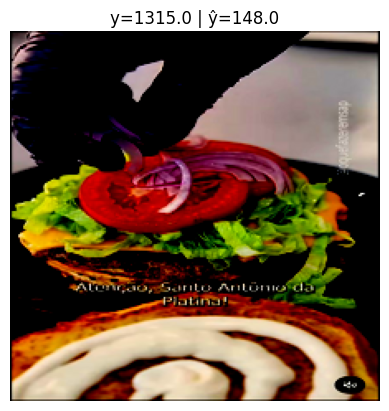

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0202277..1.1169925].


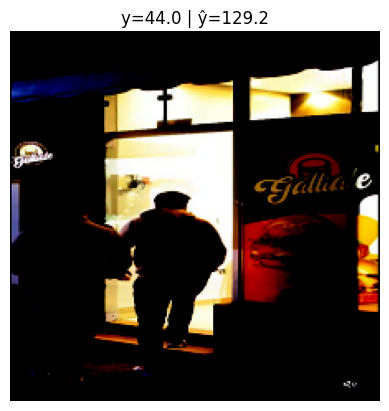

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0325711..1.0788915].


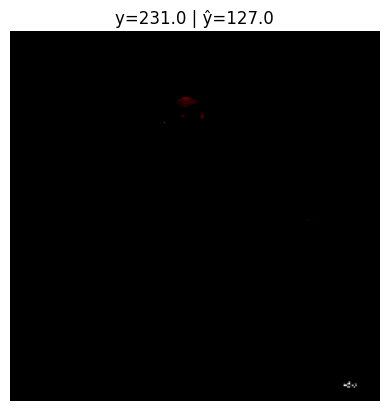

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0512233..1.0255656].


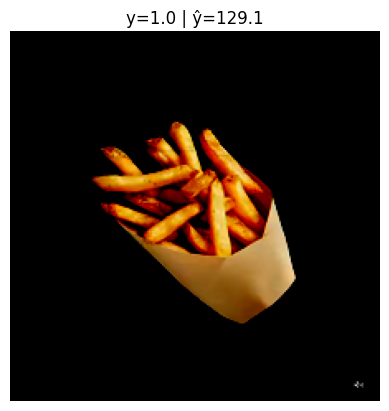

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0597646..1.0574961].


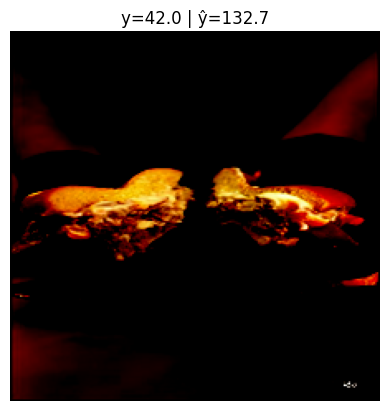

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1384323..1.1807015].


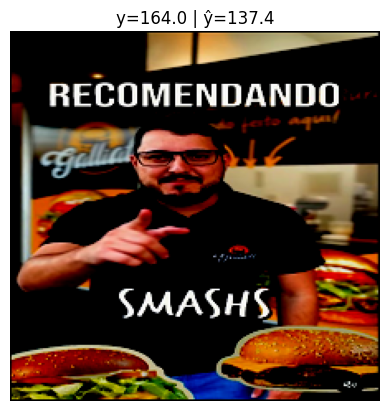

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0257689..0.98955107].


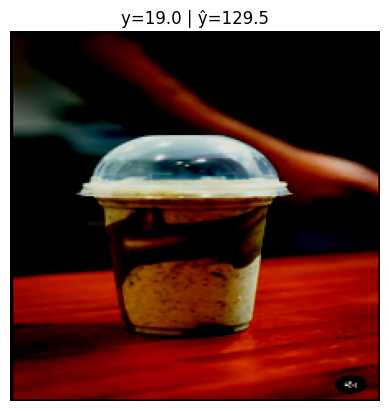

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0501082..1.05281].


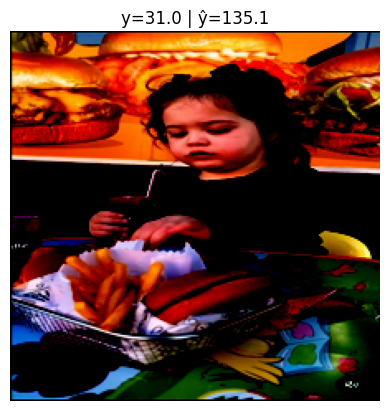

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0734546..1.1198101].


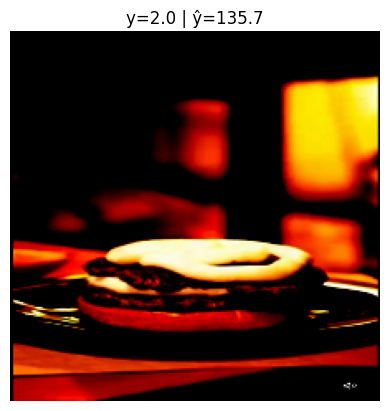

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9780319..0.99912].


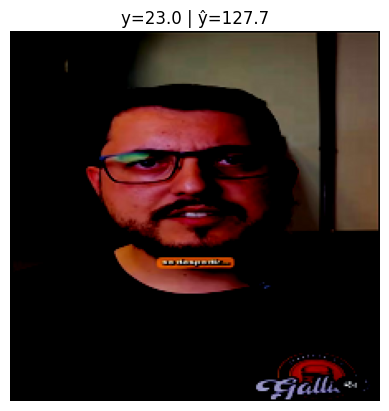

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2009752..1.0865266].


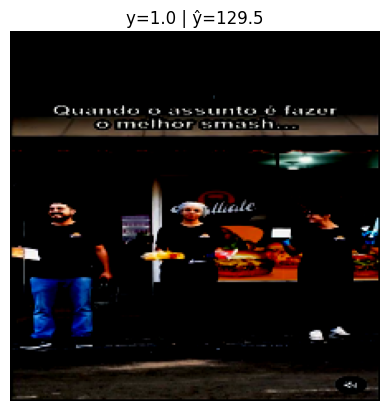

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1182492..1.1215212].


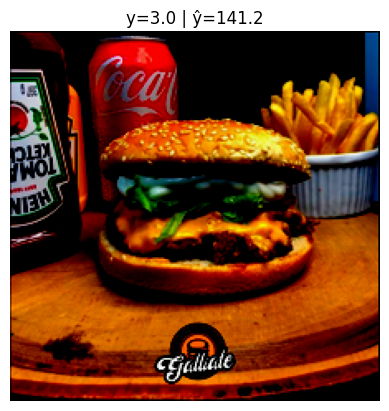

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1069922..1.082838].


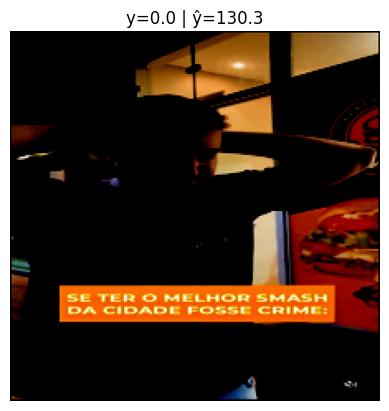

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.206542..1.0858788].


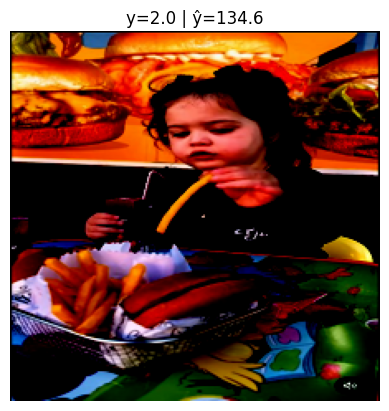

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0339711..0.9707494].


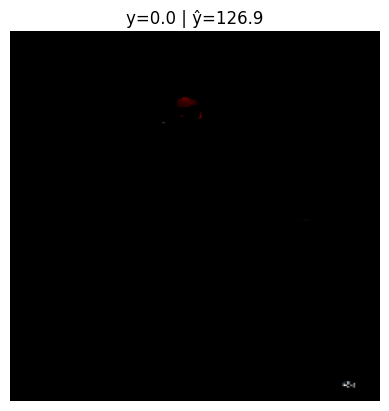

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0534568..1.1791773].


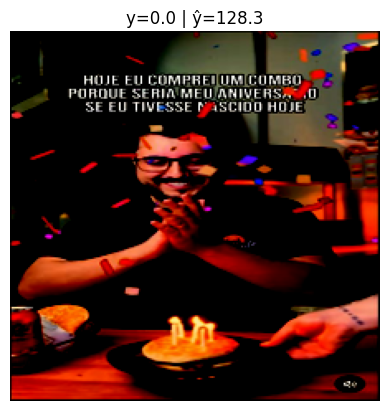

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9676042..1.035908].


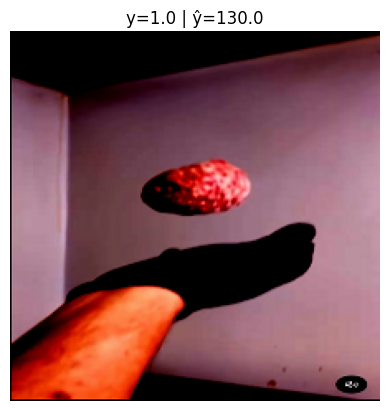

In [ ]:
for x, y, yhat in ds_hat:
    img = x.numpy()                       # tensor torna-se uma matriz NumPy
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"y={float(y.numpy()):.1f} | ŷ={float(yhat.numpy()):.1f}")
    plt.show()